# Spatial Tuning Maps

In [1]:
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import numpy as np
from tqdm import tqdm

from dataloader import BaseDataset
from utils.util import *
from param import *

datalist = ParamDir().data_list
OUTPUT_DIR = ParamDir().output_dir


## Representatives

In [2]:
def cal_sta(dataset: BaseDataset, num_par: int, neuron_id: int) -> NDArray:
    """Calculate spike triggered average.
    """
    speed = cal_velocity(dataset.coords_xy)
    binned_position = bin_pos(dataset.coords_xy[speed > 1.0], num_par) # use the data whose speed is larger than 1cm/s
    filtered_spikes = dataset.spikes[speed > 1.0, neuron_id] 

    sta = np.zeros(num_par*num_par)
    for position in sorted(np.unique(binned_position)):
        index = (binned_position == position)
        spikes_sum = np.sum(filtered_spikes[index])
        total_time = np.sum(index) / 3
        sta[int(position)-1] = spikes_sum 
    sta = np.array(sta).reshape(num_par,-1)
    
    return sta

### knockout

In [37]:
data_dir = ParamDir().data_list[1]
data_name = str(data_dir).split('/')[-1]
mouse_type = "knockout" if "KO" in data_name else "wild-type"

dataset = BaseDataset(data_dir, ParamData().mobility, ParamData().shuffle, ParamData().random_state)
num_neuron = dataset.spikes.shape[1]

with open(ParamDir().output_dir/data_name/"MI_all.pickle","rb") as f:
        results_all = pickle.load(f)

pc_beh_id, pc_event_id = get_place_cell(results_all, 0.01)

pc_beh_id

[8, 11, 15, 26, 37, 40, 47, 52, 54]

Text(0.5, 0.98, 'knockout')

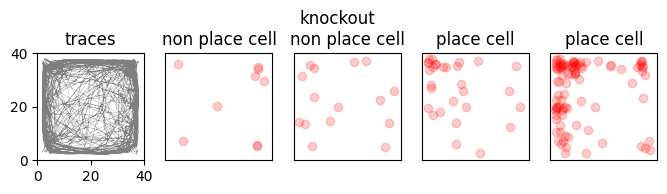

In [38]:
# show 4 neurons
fig, axes = plt.subplots(nrows=1, ncols=5 , figsize=(8,2), sharex=True, sharey=True)#,tight_layout=True
axes = axes.ravel()

# plot traces
x, y = dataset.coords_xy[:, 0] / 5, dataset.coords_xy[:, 1] / 5
axes[0].plot(x, y, lw=.2, c="black", alpha=.5)
axes[0].set_aspect("equal")
axes[0].set_xlim(0,40)
axes[0].set_ylim(0,40)
axes[0].set_title("traces")
# plot spikes
for plot_id, neuron_id in enumerate([0,1,8,54]):

    sta = cal_sta(dataset, num_par=200, neuron_id=neuron_id)
    for y, row in enumerate(sta):
        for x, spike in enumerate(row):
            if spike != 0 :
                axes[plot_id+1].scatter(x/5,y/5, c="r", alpha = .2)
    if plot_id<2:
        title = "non place cell"
    else:
        title = "place cell"
    axes[plot_id+1].set_title(title)
    axes[plot_id+1].get_yaxis().set_visible(False)
    axes[plot_id+1].get_xaxis().set_visible(False)
    axes[plot_id+1].set_aspect("equal")
    axes[plot_id+1].set_xlim(0,40)
    axes[plot_id+1].set_ylim(0,40)

fig.suptitle(mouse_type)

### wild-type

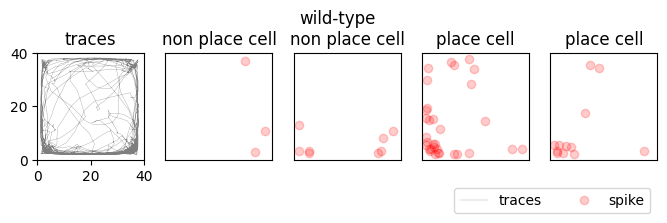

In [35]:
# show 4 neurons
fig, axes = plt.subplots(nrows=1, ncols=5 , figsize=(8,2), sharex=True, sharey=True)#,tight_layout=True
axes = axes.ravel()

# plot traces
x, y = dataset.coords_xy[:, 0] / 5, dataset.coords_xy[:, 1] / 5
line1 = axes[0].plot(x, y, lw=.2, c="black", alpha=.5, label="traces")
axes[0].set_aspect("equal")
axes[0].set_xlim(0,40)
axes[0].set_ylim(0,40)
axes[0].set_title("traces")
# plot spikes
for plot_id, neuron_id in enumerate([0,6,15,51]):

    sta = cal_sta(dataset, num_par=200, neuron_id=neuron_id)
    for y, row in enumerate(sta):
        for x, spike in enumerate(row):
            if spike != 0 :
                line2 = axes[plot_id+1].plot(x/5,y/5, 'o', c="r", alpha = .2, label="spike")
    if plot_id<2:
        title = "non place cell"
    else:
        title = "place cell"
    axes[plot_id+1].set_title(title)
    axes[plot_id+1].get_yaxis().set_visible(False)
    axes[plot_id+1].get_xaxis().set_visible(False)
    axes[plot_id+1].set_aspect("equal")
    axes[plot_id+1].set_xlim(0,40)
    axes[plot_id+1].set_ylim(0,40)

fig.suptitle(mouse_type)

lines = [line1, line2]
axes[-1].legend(line1+line2, [line1[0].get_label(), line2[0].get_label()], bbox_to_anchor=(1,-.2), ncol=2)

In [23]:
[line1, line2]

[[<matplotlib.lines.Line2D at 0x7f672d47bc40>],

## All mice
save fig to `data/interim/data-exploration`

In [5]:
ko_count, wt_count = 0, 0
for data_dir in tqdm(datalist):
    data_name = str(data_dir).split('/')[-1]

    dataset = BaseDataset(data_dir, ParamData().mobility, ParamData().shuffle, ParamData().random_state)
    
    num_neuron = dataset.spikes.shape[1]

    # show all neurons
    fig, axes = plt.subplots(
        nrows = int(np.ceil((num_neuron + 1) / 5)), 
        ncols = 5, 
        figsize = (10, 2 * int(np.ceil((num_neuron+ 1 ) / 5))),
        sharex = True,
        sharey = True
        )

    if "KO" in data_name:
        mouse_type = "knockout"
        ko_count+=1
        fig.suptitle(f"{mouse_type} {ko_count}")

    else:
        mouse_type = "wild-type"
        wt_count+=1
        fig.suptitle(f"{mouse_type} {wt_count}")

    axes = axes.ravel()
    
    # plot traces
    x, y = dataset.coords_xy[:, 0], dataset.coords_xy[:, 1]
    axes[0].plot(x, y)
    axes[0].set_aspect("equal")
    axes[0].set_xlim(0,200)
    axes[0].set_ylim(0,200)
    # plot spikes
    for neuron_id in range(len(axes)-1):
        if neuron_id < num_neuron:
            sta = cal_sta(dataset, num_par=200, neuron_id=neuron_id)
            for y, row in enumerate(sta):
                for x, spike in enumerate(row):
                    if spike != 0 :
                        axes[neuron_id+1].scatter(x,y, c="r", alpha = .2)
        # axes[neuron_id].imshow(sta)
            axes[neuron_id+1].set_title(f"n {neuron_id+1}")
        axes[neuron_id+1].get_yaxis().set_visible(False)
        axes[neuron_id+1].get_xaxis().set_visible(False)
        axes[neuron_id+1].set_aspect("equal")

    if not (OUTPUT_DIR/data_name).exists():
        (OUTPUT_DIR/data_name).mkdir()
    fig.savefig(OUTPUT_DIR/data_name/"sta.png")
    fig.clf()

100%|██████████| 12/12 [04:46<00:00, 23.83s/it]


<Figure size 1000x2200 with 0 Axes>

<Figure size 1000x2400 with 0 Axes>

<Figure size 1000x2800 with 0 Axes>

<Figure size 1000x3400 with 0 Axes>

<Figure size 1000x3600 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x4800 with 0 Axes>

<Figure size 1000x2800 with 0 Axes>

<Figure size 1000x2600 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x3200 with 0 Axes>

<Figure size 1000x2400 with 0 Axes>